In [1]:
! git clone https://github.com/sotorrent/db-scripts.git

Cloning into 'db-scripts'...
remote: Enumerating objects: 2046, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2046 (delta 0), reused 3 (delta 0), pack-reused 2039
Receiving objects: 100% (2046/2046), 22.73 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (1362/1362), done.


In [2]:
%cd db-scripts

/content/db-scripts


In [3]:
%cd sotorrent

/content/db-scripts/sotorrent


In [4]:
! pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

In [5]:
from google.cloud import bigquery
client = bigquery.Client()
bucket_name = "sde-course-project"
project = "sotorrent-org"
dataset_id = "sotorrent-org.2020_01_24"
table_id = "sotorrent-org.2020_01_24.PostReferenceGH"

destination_uri = "gs://{}/{}".format(bucket_name, "gh-post-reference.csv")
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)

Exported sotorrent-org:sotorrent-org.2020_01_21.sotorrent-org.2020_01_21.PostReferenceGH to gs://sde-course-project/gh-post-reference.csv


In [6]:
client = bigquery.Client()
bucket_name = "sde-course-project"
project = "sotorrent-org"
dataset_id = "sotorrent-org.2020_01_24"
table_id = "sotorrent-org.2020_01_24.GHCommits"

destination_uri = "gs://{}/{}".format(bucket_name, "gh-commits.csv")
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)

Exported sotorrent-org:sotorrent-org.2020_01_21.sotorrent-org.2020_01_21.GHCommits to gs://sde-course-project/gh-commits.csv


In [7]:
client = bigquery.Client()
bucket_name = "sde-course-project"
project = "sotorrent-org"
dataset_id = "sotorrent-org.2020_01_24"
table_id = "sotorrent-org.2020_01_24.GHMatches"

destination_uri = "gs://{}/{}".format(bucket_name, "gh-matches.csv")
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)

Exported sotorrent-org:sotorrent-org.2020_01_21.sotorrent-org.2020_01_21.GHMatches to gs://sde-course-project/gh-matches.csv


In [8]:
import pandas as pd

post_reference_GH = pd.read_csv("gs://sde-course-project/gh-post-reference.csv")
GH_commits = pd.read_csv("gs://sde-course-project/gh-commits.csv")
GH_matches = pd.read_csv("gs://sde-course-project/gh-matches.csv")

In [11]:
# all files with .java extension
java_db = post_reference_GH.loc[post_reference_GH["FileExt"] == "java"]
java_db.shape()

(135489, 13)


In [13]:
# select 500 random files
java_db = java_db.sample(n = 500)
java_db.shape()

(500, 13)


In [20]:
from collections import defaultdict
file_commits_map = defaultdict(list)

for file_id in java_db[java_db.columns[0]]:          # iterate files in java_db
  for gh_match_file_id in GH_matches[GH_matches.columns[0]]:     # iterate gh_matches
    if file_id == gh_match_file_id:       # if file is found in both db
      ind = GH_matches[GH_matches.columns[0]].index(file_id)      
      postIds = GH_matches[GH_matches.columns[0]][ind].split(" ")   # postIds to corresponding file
      for post_id in postIds:
        for commit_post_id in GH_commits[GH_commits.columns[5]]:
          if post_id == commit_post_id:      # if that postId is found in any particular commit
            ind = GH_commits[GH_commits.columns[5]].index(commit_post_id)    
            commit_id = GH_commits[GH_commits.columns[0]][ind]      # that file is a part of the commit
            file_commits_map[file_id].append(commit_id)

print(len(file_commits_map))

500


In [21]:
# function to compute Low-level Similarity-based Class Cohesion
def compute_lscc(java_class):
  with open(java_class, "r"):
    lines = java_class.readlines()
  k = 0  # no of methods
  l = 0  # no of attributes
  for line in lines:
    if "{" in line:
      if line.beginswith("public static"):
        k += 1   # it is a method
    if ("int" in line or "String" in line or "Array" in line) and ("{" not in line):
      l += 1    # it is a attribute

  if l == 0 and k > l:
    return 0

  if (l > 0 and k == 0) or k == 1:
    return 1

  x = l/(l + k)

  lscc = 0
  for i in range(l):
    lscc += (pow(x, i)*(pow(x, i) - 1))/(l*k*(k-1))
  
  return lscc

In [22]:
def compute_cc(java_class):
  with open(java_class, "r"):
    lines = java_class.readlines()
  k = 0  # no of methods
  l = 0  # no of attributes
  attrs = []
  methods = []
  for line in lines:
    if "{" in line:
      if line.beginswith("public static"):
        k += 1   # it is a method
        name = line.split(" ")
        name = name[-1]
        name = name.strip("(\*\)")
        methods.append(name)
    if ("int" in line or "String" in line or "Array" in line) and ("{" not in line):
      l += 1    # it is a attribute
      name = line.split(" ")
      name = line[-1]
      attrs.append(name)

  attr_method_map = defaultdict(list)   # map to store which attribute is accessed by which method

  for method in methods:
    stack = []
    for char in lines:
      words = lines.split()
      for attr in attrs:
        if attr in words:
          attr_method_map[method].append(attr)
      if char == "{":
        stack.append("{")
      else:
        stack.pop()
      if len(stack) == 1 and char == "}":
        break

  cc = 0

  for i in range(len(methods)):
    for j in range(i+1, len(methods)):
      intersect = len(set(attr_method_map[methods[i]]).intersection(set(attr_method_map[methods[j]])))
      union = len(set(attr_method_map[methods[i]]).union(set(attr_method_map[methods[j]])))
      cc += intersect/union
  
  cc = 2*cc/(k*(k-1))

  return cc

In [23]:
pre_snap_cc = []
post_snap_cc = []

pre_snap_lscc = []
post_snap_lscc = []

for file in file_commits_map:
  pre_snap_cc.append(compute_cc(file_commits_map[file][0]))
  post_snap_cc.append(compute_cc(file_commits_map[file][1]))

  pre_snap_lscc.append(compute_lscc(file_commits_map[file][0]))
  post_snap_lscc.append(compute_lscc(file_commits_map[file][1]))

In [24]:
constant_cc = 0
constant_lscc = 0

improving_cc = 0
improving_lscc = 0

deteriorating_cc = 0
deteriorating_lscc = 0

deteriorating_commits_cc = []
deteriorating_commits_lscc = []

for i in range(500):
  if pre_snap_cc[i] == post_snap_cc[i]:
    constant_cc += 1
  if pre_snap_cc[i] > post_snap_cc[i]:
    deteriorating_cc += 1
    deteriorating_commits_cc.append(post_snap_cc[i])
  if pre_snap_cc[i] < post_snap_cc[i]:
    improving_cc += 1

  if pre_snap_lscc[i] == post_snap_lscc[i]:
    constant_lscc += 1
  if pre_snap_lscc[i] > post_snap_lscc[i]:
    deteriorating_lscc += 1
    deteriorating_commits_lscc.append(post_snap_lscc[i])
  if pre_snap_lscc[i] < post_snap_lscc[i]:
    improving_lscc += 1

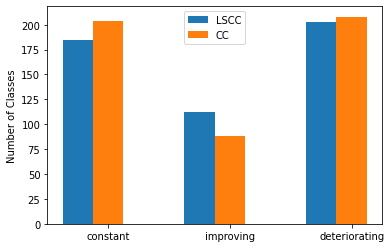

In [3]:
import numpy as np
import matplotlib.pyplot as plt

cc = [constant_cc, improving_cc, deteriorating_cc]
lscc = [constant_lscc, improving_lscc, deteriorating_lscc]

barwidth = 0.25
br1 = np.arange(3)
br2 = [x + barwidth for x in br1]

plt.bar(br1, lscc, width = barwidth, label = 'LSCC')
plt.bar(br2, cc, width = barwidth, label = 'CC')

plt.ylabel('Number of Classes')
plt.xticks([r + barwidth for r in range(3)], ['constant', 'improving', 'deteriorating'])
 
plt.legend()
plt.show()

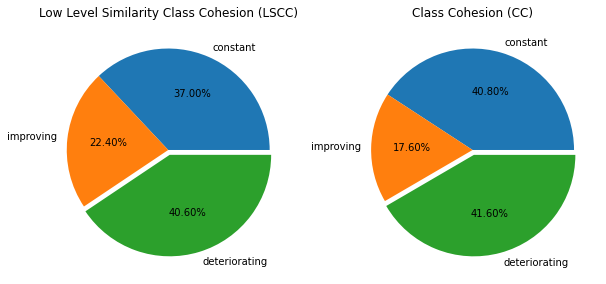

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
labels = ["constant", "improving", "deteriorating"]
explode = [0, 0, 0.05]

ax1.pie(lscc, labels = labels, explode = explode, autopct = lambda p: '{:.2f}%'.format(p))
ax2.pie(cc, labels = labels, explode = explode, autopct = lambda p: '{:.2f}%'.format(p))

ax1.set_title("Low Level Similarity Class Cohesion (LSCC)")
ax2.set_title("Class Cohesion (CC)")

plt.show()

In [20]:
full_cc = 0
partial_cc = 0
not_cc = 0

full_cc_commit = ""
partial_cc_commit = ""
not_cc_commit = ""

for commit in deteriorating_commits_cc:
  for key, value in file_commits_map:
    if commit in value:
      pre_snap_val = compute_cc(value[0])
      for val in value[1:]:
        if compute_cc(val) > pre_snap_val:
          full_cc += 1
          full_cc_commit = val
        elif compute_cc(val) > 0.5*pre_snap_val:
          partial_cc += 1
          partial_cc_commit = val
        else:
          not_cc += 1
          not_cc_commit = val

full_lscc = 0
partial_lscc = 0
not_lscc = 0

full_lscc_commit = ""
partial_lscc_commit = ""
not_lscc_commit = ""

for commit in deteriorating_commits_lscc:
  for key, value in file_commits_map:
    if commit in value:
      pre_snap_val = compute_lscc(value[0])
      for val in value[1:]:
        if compute_lscc(val) > pre_snap_val:
          full_lscc += 1
          full_lscc_commit = val
        elif compute_lscc(val) > 0.5*pre_snap_val:
          partial_lscc += 1
          partial_lscc_commit = val
        else:
          not_lscc += 1
          not_lscc_commit = val

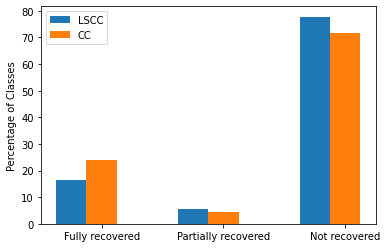

In [22]:
cc = [full_cc, partial_cc, not_cc]
lscc = [full_lscc, partial_lscc, not_lscc]

for i in range(3):
  cc[i] = cc[i]*100/sum(cc)
  lscc[i] = lscc[i]*100/sum(lscc)

barwidth = 0.25
br1 = np.arange(3)
br2 = [x + barwidth for x in br1]

plt.bar(br1, lscc, width = barwidth, label = 'LSCC')
plt.bar(br2, cc, width = barwidth, label = 'CC')

plt.ylabel('Percentage of Classes')
plt.xticks([r + barwidth for r in range(3)], ['Fully recovered', 'Partially recovered', 'Not recovered'])
 
plt.legend()
plt.show()

In [23]:
def plot_cohesion_history(commit):
  lscc_scores = []
  cc_scores = []
  dates = []
  for key, value in file_commits_map:
    if commit in value:
      for val in value:
        lscc_scores.append(compute_lscc(val))
        cc_scores.append(compute_cc(val))
        for commit_id in GH_commits[GH_commits.columns[0]]:
          if commit_id == commit:
            ind = GH_commits[GH_commits.columns[0]].index(commit_id)
            date = GH_commits[GH_commits.columns[3]][ind]
            dates.append(date)
  
  fig, ax = plt.subplots()
  ax.plot(lscc_scores, label = "LSCC", marker = "o")
  ax.plot(cc_scores, label = "CC", marker = "o")
  ax.set_xticklabels([""] + dates, rotation=90)
  ax.legend()
  plt.show()

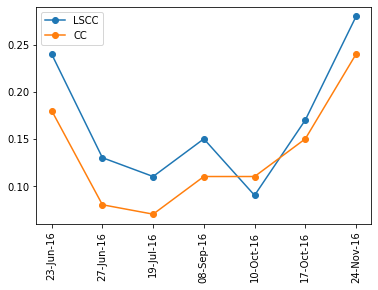

In [35]:
plot_cohesion_history(full_cc_commit)

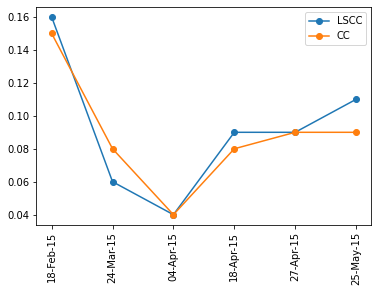

In [36]:
plot_cohesion_history(partial_cc_commit)

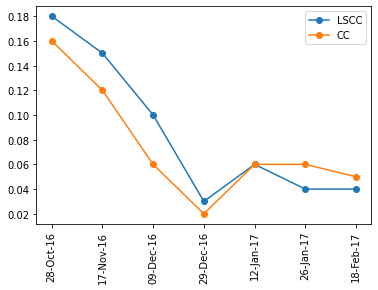

In [37]:
plot_cohesion_history(not_cc_commit)